# Import important libraries

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout, BatchNormalization
import numpy as np
import matplotlib.pyplot as plt
import cv2 

# Make sure to use the GPU for fast training

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num of GPUs found", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num of GPUs found 1


# Data

### The images are stored in with_mask and without_mask folders in dataset folder in my PC.
### Data can be downloaded from kaggle and loaded
### We load the data in list and give labels accordingly as 1 - Masked, 0 - Without Mask
### Total images stored in list 'X' and respective labels in 'y'

In [3]:
mask_path = r'C:\Users\mishr\Downloads\Face-Mask-Detection-master\Face-Mask-Detection-master\dataset\with_mask'
without_mask_path = r'C:\Users\mishr\Downloads\Face-Mask-Detection-master\Face-Mask-Detection-master\dataset\without_mask'

X = []
y = []
for image in os.listdir(mask_path):
    img_path = os.path.join(mask_path, image)
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (150,180))
        X.append(img)
        y.append(int(1))
    
for image in os.listdir(without_mask_path):
    img_path = os.path.join(without_mask_path, image)
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (150,180))
        X.append(img)
        y.append(int(0))
    

# Conversion
### The list X is converted in a numpy array i.e. tensor with 4 dimensions
### y is flattened

In [4]:
X = np.array(X)
y = np.array(y).flatten()
X.shape

(3810, 180, 150, 3)

# Splitting
### Using Sklearn to split data into train and test samples with test size equal to 30 % of the samples
### Normalization of train and test images are done after splitting

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.3)

X_train = X_train/255.0
X_test = X_test/255.0

# Creating the CNN Model

### We use 3 Conv2D layers with 32, 64 and 128 filters respectively with relu activations. These layers are followed by Maxpooling of 2x2 and  BatchNormalization layers.
### The dense layers has 150 neurons with relu activation and a dropout of 0.2
### The output layer has 2 neurons with softmax activation.
### We use adam as optimizer, accuracy as the metrics and sparse_categorical_crossentropy as the loss function.

In [6]:
model = Sequential([
                    Conv2D(32, (3,3), activation = 'relu', input_shape = (X_train.shape[1:])),
                    MaxPooling2D((2,2)),
                    BatchNormalization(),
                    Conv2D(64, (3,3), activation = 'relu'),
                    MaxPooling2D((2,2)),
                    BatchNormalization(),
                    Conv2D(128, (3,3), activation = 'relu'),
                    MaxPooling2D((2,2)),
                    BatchNormalization(),
                    Flatten(),
                    Dropout(0.2),
                    Dense(150, activation = 'relu'),
                    Dropout(0.2),
                    Dense(2, activation = 'softmax')
                    ])

In [7]:
model.compile(optimizer = 'adam',
              metrics = ['accuracy'],
              loss = 'sparse_categorical_crossentropy')

# Augmenting the training data
### We use ImageDataGenerator for augmenting with following parameters

### i. width shift
### ii. height shift
### iii. rotation range
### iv. horizontal flip
### v. zoom range

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range = 0.25,
                            height_shift_range = 0.25,
                            rotation_range = 25,
                            horizontal_flip = True,
                            zoom_range = 0.5,
                            )

image_data = datagen.flow(X_train, y_train, batch_size = 32)
steps_per_epoch = X_train.shape[0]//32

# CustomCallback

### We create a custom callbackclass to monitor the validation accuracy.
### Once the validation accuracy exceeds 98 % threshold , the training is stopped.

In [9]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        if logs.get("val_accuracy") > 0.98:
            print("Accuracy reached over 98% , quitting training")
            self.model.stop_training = True

# Fitting the model

### We use the flow created using ImageDataGenerator to train the model.
### We are not sure of no of epochs so we set it to 100 and trust our callback class to decide the training by monitoring the validation accuracy
### At 91st epoch the model attains 98.08 % accuracy and training stops

In [10]:

r = model.fit(image_data,
              validation_data = (X_test, y_test),
              epochs = 100,
              steps_per_epoch= steps_per_epoch,
              callbacks = [CustomCallback()]
              )

Epoch 1/100
83/83 [==============================] - 26s 209ms/step - loss: 4.6108 - accuracy: 0.7810 - val_loss: 0.9353 - val_accuracy: 0.5398
Epoch 2/100
83/83 [==============================] - 16s 187ms/step - loss: 2.2296 - accuracy: 0.8027 - val_loss: 4.2905 - val_accuracy: 0.4821
Epoch 3/100
83/83 [==============================] - 15s 186ms/step - loss: 1.2679 - accuracy: 0.8034 - val_loss: 1.1271 - val_accuracy: 0.5853
Epoch 4/100
83/83 [==============================] - 15s 184ms/step - loss: 0.7582 - accuracy: 0.8425 - val_loss: 0.8573 - val_accuracy: 0.6912
Epoch 5/100
83/83 [==============================] - 15s 182ms/step - loss: 0.5314 - accuracy: 0.8497 - val_loss: 0.6537 - val_accuracy: 0.6815
Epoch 6/100
83/83 [==============================] - 15s 183ms/step - loss: 0.4490 - accuracy: 0.8698 - val_loss: 0.2251 - val_accuracy: 0.9291
Epoch 7/100
83/83 [==============================] - 15s 184ms/step - loss: 0.4167 - accuracy: 0.8634 - val_loss: 0.2456 - val_accuracy:

83/83 [==============================] - 15s 176ms/step - loss: 0.1898 - accuracy: 0.9321 - val_loss: 0.1241 - val_accuracy: 0.9571
Epoch 58/100
83/83 [==============================] - 14s 174ms/step - loss: 0.1605 - accuracy: 0.9423 - val_loss: 0.2038 - val_accuracy: 0.9326
Epoch 59/100
83/83 [==============================] - 15s 176ms/step - loss: 0.1903 - accuracy: 0.9347 - val_loss: 0.1466 - val_accuracy: 0.9458
Epoch 60/100
83/83 [==============================] - 15s 177ms/step - loss: 0.1818 - accuracy: 0.9404 - val_loss: 0.2269 - val_accuracy: 0.9003
Epoch 61/100
83/83 [==============================] - 15s 175ms/step - loss: 0.1609 - accuracy: 0.9397 - val_loss: 0.1480 - val_accuracy: 0.9510
Epoch 62/100
83/83 [==============================] - 15s 175ms/step - loss: 0.1917 - accuracy: 0.9306 - val_loss: 0.1300 - val_accuracy: 0.9519
Epoch 63/100
83/83 [==============================] - 15s 176ms/step - loss: 0.1621 - accuracy: 0.9393 - val_loss: 0.0857 - val_accuracy: 0.972

# Plotting the history
### We can see the loss and accuracy plotted.
### Due to augmentation the model avoids overfitting

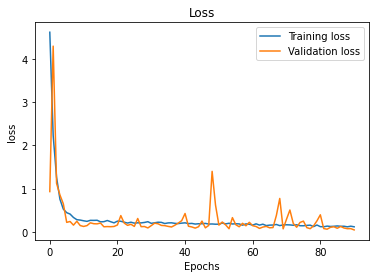

In [11]:
plt.plot(r.history['loss'], label = 'Training loss')
plt.plot(r.history['val_loss'], label = 'Validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.title('Loss')
plt.legend();

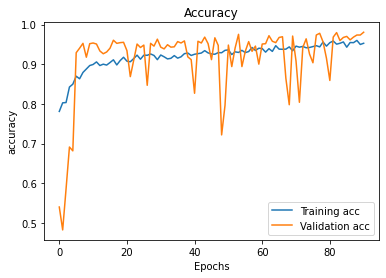

In [12]:
plt.plot(r.history['accuracy'], label = 'Training acc')
plt.plot(r.history['val_accuracy'], label = 'Validation acc')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.title('Accuracy')
plt.legend();

# Prediction
### We see some random images and the labels predicted.
### We create a labels dictionary to store the true label.

In [57]:
prediction_x_test = model.predict(X_test).argmax(axis = 1)

In [58]:
labels = {1:"Masked", 0:"Without_Mask"}

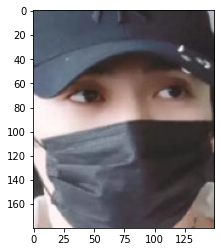

In [59]:
plt.imshow(X_test[150])

In [60]:
print("predicted label is",labels[prediction_x_test[120]])

predicted label is Masked


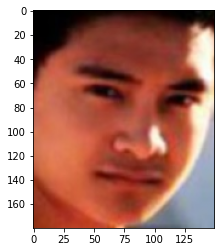

In [61]:
plt.imshow(X_test[251])

In [62]:
print("predicted label is",labels[prediction_x_test[251]])

predicted label is Without_Mask


# Looking at wrong classifications
### a random wrong sample is picked from X_test

In [68]:
g = np.where(prediction_x_test!=y_test)

Text(0.5, 1.0, 'Without_Mask has been predicted as Masked')

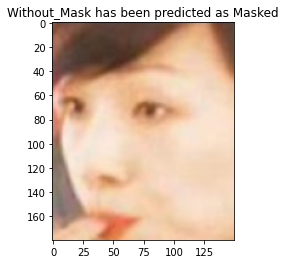

In [74]:
wrong_choice = np.random.choice(g[0])
plt.imshow(X_test[wrong_choice])
plt.title(f'{labels[y_test[wrong_choice]]} has been predicted as {labels[prediction_x_test[wrong_choice]]}')